<a href="https://colab.research.google.com/github/Guillermo-03/MachineLearning_Project-1/blob/main/CL_Bi_Modal_Model_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dependencies

In [41]:
!pip install torch torchvision --quiet
!pip install nuscenes-devkit --no-deps --quiet
!pip install pyquaternion --quiet
!pip install Pillow --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet

In [42]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from nuscenes.nuscenes import NuScenes
from PIL import Image
from IPython.display import clear_output, display
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import AutoTokenizer, AutoModel

In [43]:
# Paths
base_path = "/content/drive/MyDrive/CRA_REU-Summer2025"
doscenes_csv = os.path.join(base_path, "doScenes", "doScenesAnnotations_Annotator_5.csv")
nuscenes_root = os.path.join(base_path, "nuScenes")
5
# Checking doScenes annotations
df = pd.read_csv(doscenes_csv)
print("Loaded doScenes:", df.shape)

# Checking nuScenes data
nusc = NuScenes(version='v1.0-mini', dataroot=nuscenes_root, verbose=True)

Loaded doScenes: (955, 3)
Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.027 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


# Functions

In [44]:
# Contrastive Loss Function
def nt_xent_loss(video_embs, text_embs, temperature=0.1):
    # Computing Similarity Matrix
    sim_matrix = torch.mm(video_embs, text_embs.t()) / temperature

    # Labels are 0,1,...,B-1 so that sim_matrix[i,i] are positives
    labels = torch.arange(sim_matrix.size(0), device=sim_matrix.device)
    loss = nn.CrossEntropyLoss()(sim_matrix, labels)
    return loss

# Given a scene number, return the corresponding front camera image path from nuScenes.
def get_first_cam_front_image_path(scene_number):
    scene_index = scene_number - 1

    scene = nusc.scene[scene_index]

    first_sample_token = scene['first_sample_token']
    sample = nusc.get('sample', first_sample_token)

    cam_front_token = sample['data']['CAM_FRONT']
    cam_front_data = nusc.get('sample_data', cam_front_token)

    image_path = os.path.join(nusc.dataroot, cam_front_data['filename'])
    return image_path


# Display a single frame of inputted Scene
def display_scene():
  try:
    scene_number = int(input("Enter a scene number: "))
    image_path = get_first_cam_front_image_path(scene_number)
  except (IndexError, ValueError):
    print("Invalid Scene Selection! Please enter a number between 1 and 10")
  else:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Scene {scene_number} - First CAM_FRONT Frame")
    plt.show()


# Display all frames of an inputted scene
def view_cam_front_sequence():
    try:
        scene_number = int(input("Enter a scene number: "))
        if scene_number < 1 or scene_number > 10:
            raise IndexError("Scene number out of bounds.")

        scene = nusc.scene[scene_number - 1]
        sample_token = scene['first_sample_token']

        cam_front_images = []

        while sample_token:
            sample = nusc.get('sample', sample_token)
            cam_token = sample['data']['CAM_FRONT']
            cam_data = nusc.get('sample_data', cam_token)
            cam_path = os.path.join(nusc.dataroot, cam_data['filename'])
            cam_front_images.append(cam_path)
            sample_token = sample['next'] if sample['next'] else None

        print(f"Loaded {len(cam_front_images)} CAM_FRONT frames for Scene {scene_number}")

        # Interactive display
        index = widgets.IntSlider(min=0, max=len(cam_front_images)-1, step=1, description="Frame:")

        def show_frame(i):
            clear_output(wait=True)
            img = Image.open(cam_front_images[i])
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Scene {scene_number} - Frame {i+1}/{len(cam_front_images)}")
            plt.show()
            display(index)

        index.observe(lambda change: show_frame(change.new), names='value')
        show_frame(0)

    except (ValueError, IndexError):
        print("Invalid Scene Selection. Please enter a number between 1 and 10")

# Preserve frames in a clip to bypass default_collate that pytorch uses for DataLoader
def collate_fn(batch):
    videos = []
    instrs = []
    for video, instructions in batch:
        videos.append(video)         # video: Tensor (T_i,3,224,224)
        instrs.append(instructions)  # instructions: list of str
    return videos, instrs


# Classes

In [45]:
# Defining Dataset
class SceneLevelDataset(Dataset):
    def __init__(self, nusc, annotations_df):
      self.nusc = nusc

      # Mapping Instructions to Scenes
      # For scenes with multiple annotations, it looks like: [instruction1, instruction2, …]
      self.scene_to_instructions = {}

      for _, row in annotations_df.iterrows():
          sn = int(row['Scene Number'])
          instr = row['Instruction']

          if sn not in self.scene_to_instructions:
              self.scene_to_instructions[sn] = []

          self.scene_to_instructions[sn].append(instr)

      # Replacing any NaN-only lists with a default instruction
      default_instr = "maintain normal driving motion"
      for sn, instr_list in self.scene_to_instructions.items():
          # Filter out non-string or NaN entries
          cleaned = [inst for inst in instr_list if isinstance(inst, str) and not pd.isna(inst)]

          # If nothing left after cleaning, use default
          if not cleaned:
              cleaned = [default_instr]
          self.scene_to_instructions[sn] = cleaned

      # Creating a list of scenes that have an annotation
      self.scene_numbers = list(self.scene_to_instructions.keys())

      # Creating lookup tables for quick data access
      self.scene_num_to_token = {}
      self.first_tokens = {}

      for scene in self.nusc.scene:
          name = scene['name']
          parts = name.split('-')

          try:
              num = int(parts[-1])
              token = scene['token']
              self.scene_num_to_token[num] = token
                # storing first sample token
              rec = self.nusc.get('scene', token)
              self.first_tokens[token] = rec['first_sample_token']
          except ValueError:
              continue

      # Image transform
      self.transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
      ])

    def __len__(self):
      return len(self.scene_numbers)

    def __getitem__(self, idx):
      scene_num = self.scene_numbers[idx]
      token = self.scene_num_to_token.get(scene_num)

      if token is None:
          raise IndexError(f"Scene {scene_num} not in nuScenes-mini")

        # Walk all front‐cam sample tokens in this scene
      sample_tokens = []
      curr = self.first_tokens[token]

      while curr:
        sample_tokens.append(curr)
        rec = self.nusc.get('sample', curr)
        curr = rec['next'] if rec['next'] else None

        # Load all frames
      frames = []
      for st in sample_tokens:
        samp = self.nusc.get('sample', st)
        cam_tok = samp['data']['CAM_FRONT']
        data = self.nusc.get('sample_data', cam_tok)
        path = os.path.join(self.nusc.dataroot, data['filename'])
        img = Image.open(path).convert('RGB')
        frames.append(self.transform(img))

        # Stack frames into a clip tensor (T, 3, 224, 224)
      video = torch.stack(frames)
      instructions = self.scene_to_instructions[scene_num]  # list of strings
      return video, instructions


# Defining Model
# Maps scene video and natural language to the same embedding space
class BiModalSequenceModel(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()

        # Load ImageNet-pretrained ResNet-18.
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Removing final classification layer and keeping everything up to global avg-pool.
        modules = list(resnet.children())[:-1]   # all layers except the last FC
        self.backbone = nn.Sequential(*modules)

        # Freeze backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Projection head for video features
        in_features = resnet.fc.in_features       # the dimension of the pooled feature
        self.image_proj = nn.Linear(in_features, embed_dim)

        # Text encoder: DistilBERT and projection
        self.tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.text_encoder = AutoModel.from_pretrained('distilbert-base-uncased')

        # Projection head for text features to shared space
        text_hidden = self.text_encoder.config.hidden_size
        self.text_proj = nn.Linear(text_hidden, embed_dim)

        # L2 normalization
        self.normalize = nn.functional.normalize

    def encode_video(self, video):
        """
        video:  Tensor (B, T, 3, H, W)   — batch of scene clips (all frames)
        return: Tensor (B, D)            — L2-normalized scene embeddings
        B = Batch Size
        T = Total # of frames in scene
        D  = Embedding Dimensions
        """
        B, T, C, H, W = video.shape

        # Collapse (B, T) so we can feed frames through ResNet in a single pass
        video = video.view(B * T, C, H, W)
        feats = self.backbone(video)               # (B*T, in_features, 1, 1)
        feats = feats.view(B, T, -1)               # (B, T, in_features)

        # Average pool over time dimension
        pooled = feats.mean(dim=1)                 # (B, in_features)

        # Projection
        z = self.image_proj(pooled)                # (B, embed_dim)
        z = self.normalize(z, dim=-1)
        return z

    def encode_text(self, texts):
        """
        texts: list of strings of length B (or B separate calls)
        returns: Tensor of shape (len(texts), embed_dim), L2-normalized
        """
        # Tokenize and batch
        tokens = self.tokenizer(texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True)
        # Move tokens to same device as the model
        device = next(self.parameters()).device

        for key, tensor in tokens.items():
          tokens[key] = tensor.to(device)

        out = self.text_encoder(**tokens)
        # Use the [CLS] token embedding (first token) as sentence embedding
        pooled = out.last_hidden_state[:, 0, :]     # (B, hidden_size)

        # Projection
        z = self.text_proj(pooled)                  # (B, embed_dim)
        z = self.normalize(z, dim=-1)
        return z

    def forward(self, video, texts):
        """
        video: Tensor (B, T, 3, H, W)
        texts: list of B strings
        returns: (video_embeddings, text_embeddings)
        both of shape (B, embed_dim)
        """
        v = self.encode_video(video)
        t = self.encode_text(texts)
        return v, t

# Sanity Check #1: Checking Display Functions


In [46]:
# Uncomment this to view a single frame from the scene
# display_scene()

# Uncomment this to view the scene sequence
# view_cam_front_sequence()

# nuScenes Token IDs

In [47]:
# Getting Scene Tokens
mini_scene_tokens = []
for scene in nusc.scene:
    mini_scene_tokens.append(scene['token'])

# Mapping each scene token to its scene number
token_to_number = {}
for scene in nusc.scene:
    scene_token = scene['token']
    scene_name = scene['name']

    try:
        number = int(scene_name.split('-')[-1])  # extract 0102 -> 102
        token_to_number[scene_token] = number
    except:
        continue

# Finding the scene numbers from nuScenes-mini
mini_scene_numbers = []
for token in mini_scene_tokens:
    if token in token_to_number:
        mini_scene_numbers.append(token_to_number[token])

print("Scene Numbers in nuScenes-mini:", mini_scene_numbers)

# Filtering doScenes annotations based on presenet nuScene scenes
filtered_doscenes = df[df['Scene Number'].isin(mini_scene_numbers)].reset_index(drop=True)
print(f"\nTotal of: {len(filtered_doscenes)} Matched instructions from doScenes")

Scene Numbers in nuScenes-mini: [61, 103, 553, 655, 757, 796, 916, 1077, 1094, 1100]

Total of: 12 Matched instructions from doScenes


# Combining nuScenes and doScenes



In [48]:
# Build a mapping from doScenes Scene Number to nuScenes scene token
scene_number_to_token = {}

for scene in nusc.scene:
    try:
        # Extract number from scene name (scene-0102" -> 102)
        scene_num = int(scene['name'].split('-')[-1])
        scene_number_to_token[scene_num] = scene['token']
    except ValueError:
        continue

# Map tokens into doScenes DataFrame
df['scene_token'] = df['Scene Number'].map(scene_number_to_token)

# Drop rows with no match (no token found)
filtered_doscenes = df.dropna(subset=['scene_token']).reset_index(drop=True)

print(f"Filtered doScenes: {len(filtered_doscenes)} entries matched to nuScenes-mini scenes.\n")
filtered_doscenes.head()

Filtered doScenes: 12 entries matched to nuScenes-mini scenes.



,Scene Number,Instruction Type,Instruction,scene_token
0,61,NaN,Switch to the left lane.,cc8c0bf57f984915a77078b10eb33198
1,61,d,Follow the vehicle in front of you.,cc8c0bf57f984915a77078b10eb33198
2,103,NaN,NaN,fcbccedd61424f1b85dcbf8f897f9754
3,103,d,Slow down when the car from the left hand side...,fcbccedd61424f1b85dcbf8f897f9754
4,553,NaN,NaN,6f83169d067343658251f72e1dd17dbc


# Sanity Check #2: Checking Dataset

Number of unique scenes: 10

Enter a scene number (1–10): 4

Scene Number: 655
Number of frames in clip: 41
Instructions for this scene:
 - maintain normal driving motion



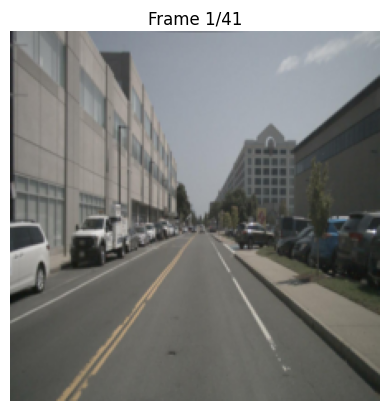

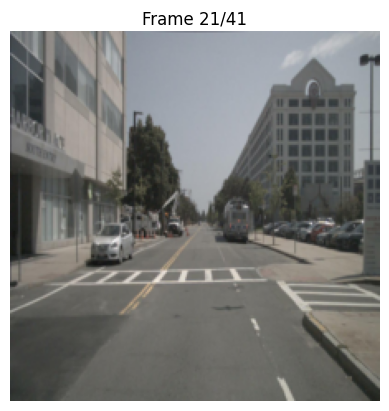

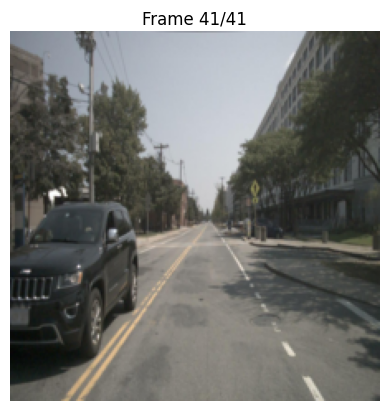

In [49]:
# Verifiying scenes align with annotations
dataset = SceneLevelDataset(nusc, filtered_doscenes)
print(f"Number of unique scenes: {len(dataset)}\n")

try:
    scene_input = int(input(f"Enter a scene number (1–{len(dataset)}): "))
    if scene_input < 1 or scene_input > len(dataset):
        raise IndexError
except ValueError:
    print(f"Invalid input! Please enter an integer between 1 and {len(dataset)}.")
except IndexError:
    print(f"Invalid choice! Please select a scene number between 1 and {len(dataset)}.")
else:
    idx = scene_input - 1
    scene_id = dataset.scene_numbers[idx]
    video, instr_list = dataset[idx]

    print(f"\nScene Number: {scene_id}")
    print(f"Number of frames in clip: {video.shape[0]}")
    print("Instructions for this scene:")
    for inst in instr_list:
        print(f" - {inst}")
    print()

    total_frames = video.shape[0]
    for frame_idx in [0, total_frames // 2, total_frames - 1]:
        frame = video[frame_idx]
        img = transforms.ToPILImage()(frame)
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Frame {frame_idx+1}/{total_frames}")
        plt.show()

# Sanity Check #3: DataLoader

In [50]:
dataset = SceneLevelDataset(nusc, filtered_doscenes)

# # Debug Loader to check all of our data points
debug_loader = DataLoader(
    dataset,
    batch_size=1,            # Scenes per batch
    shuffle=False,
    num_workers=0,           # No parallel loading
    collate_fn=collate_fn
)

# Sanity‐check looping over our current dataset (debug_loader, not DataLoader)
for batch_idx, (videos_list, instrs_list) in enumerate(debug_loader):
    clip      = videos_list[0]
    instrs    = instrs_list[0]
    scene_num = dataset.scene_numbers[batch_idx]

    clip_ds, instrs_ds = dataset[batch_idx]

    print(f"\nBatch idx = {batch_idx+1} -> Scene {scene_num}")
    print(" • Loader clip frames :", clip.shape[0])
    print(" • Dataset clip frames:", clip_ds.shape[0])
    print(" • Loader instrsuctions   :", instrs)
    print(" • Dataset instructions   :", instrs_ds)


Batch idx = 1 -> Scene 61
 • Loader clip frames : 39
 • Dataset clip frames: 39
 • Loader instrsuctions   : ['Switch to the left lane.', 'Follow the vehicle in front of you.']
 • Dataset instructions   : ['Switch to the left lane.', 'Follow the vehicle in front of you.']

Batch idx = 2 -> Scene 103
 • Loader clip frames : 40
 • Dataset clip frames: 40
 • Loader instrsuctions   : ['Slow down when the car from the left hand side starts to turn onto the road.']
 • Dataset instructions   : ['Slow down when the car from the left hand side starts to turn onto the road.']

Batch idx = 3 -> Scene 553
 • Loader clip frames : 41
 • Dataset clip frames: 41
 • Loader instrsuctions   : ['maintain normal driving motion']
 • Dataset instructions   : ['maintain normal driving motion']

Batch idx = 4 -> Scene 655
 • Loader clip frames : 41
 • Dataset clip frames: 41
 • Loader instrsuctions   : ['maintain normal driving motion']
 • Dataset instructions   : ['maintain normal driving motion']

Batch idx 

# Defining Model and Optimizer

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiModalSequenceModel(embed_dim=256).to(device)
print("Model initialized on", device)

optimizer = optim.Adam(model.parameters(), lr=3e-4)

Model initialized on cpu


# Testing Loss and Optimizer

In [52]:
loader = DataLoader(
    dataset,
    batch_size=2,         # number of scenes per batch
    shuffle=True,         # randomize order each epoch
    num_workers=0,        # no parallel workers (safe for Python objects)
    collate_fn=collate_fn # custom collate to return lists
)

model.train()
optimizer.zero_grad()

# Fetch one batch of 2 scenes
videos_batch, instrs_batch = next(iter(loader))  # videos_batch is list of 2 clips

# Encode all videos into one (B, D) tensor
v_embs = []

for video_clip in videos_batch:
    v = video_clip.unsqueeze(0).to(device)       # (1, T, 3, H, W)
    v_emb = model.encode_video(v)                # (1, D)
    v_embs.append(v_emb)
v_embs = torch.cat(v_embs, dim=0)                # (B=2, D)

# Encode & average all instruction lists into one (B, D) tensor
t_embs = []

for instr_list in instrs_batch:
    te = model.encode_text(instr_list)           # (N_i, D)
    te_avg = te.mean(dim=0, keepdim=True)        # (1, D)
    t_embs.append(te_avg)
t_embs = torch.cat(t_embs, dim=0)                # (B=2, D)

# Compute one contrastive loss over the batch
loss = nt_xent_loss(v_embs, t_embs)

# Backpropagate and step
loss.backward()
optimizer.step()

print("Smoke‐test batch loss:", loss.item())

Smoke‐test batch loss: 0.7114397287368774


Shown above is the modeling of the relationship between natural language and vision, which ran end-to-end without any errors, establishing that the pipeline is functioning correctly and providing a basis for tri tri-modal model. Now that we have this running, what's next is modeling the relationship between language, vision, and trajectory. We can do this by concatenating the embedded language and vision vectors and model the relationship between (Language + Vision) and Trajectory.